- now we start with week 6
- from this

In [1]:
from helper import *
from stats import *
from imp import reload   
import helper
import stats
reload(helper)
reload(stats)



<module 'stats' from 'C:\\Users\\dell\\stats.py'>

- number of cores, set this number according to your computer

In [2]:
CORE_NUM = int(os.environ['NUMBER_OF_PROCESSORS'])
CORE_NUM

16

In [3]:
product_list = ["rb", "hc", "i", "j", "jm"]

- sample period

In [4]:
period = 4096

- get all of the days

In [5]:
import dask
from dask import compute, delayed

In [6]:
all_dates = os.listdir(DATA_PATH + product_list[0])
all_dates.sort()
all_dates = np.array(all_dates)
n_days = len(all_dates)
n_days
## 915

915

In [7]:
train_sample = all_dates<"2018"
test_sample = all_dates>"2018"
date_str = [n[0:8] for n in all_dates]
format_dates = np.array([pd.to_datetime(d) for d in date_str])

- let's begin with week 6

- this week we focus on portfolio optimization which gives weights to each strategy


- we have got several signals and each signals have several strategies right now
- let's put them together now


- we can write a function to generage signal backtesting result

- first we create a directory to save the signal backtesting result

- then we can write a function to perform the job

In [8]:
os.makedirs(HEAD_PATH+"/all signal", exist_ok=True)
dire_signal_list = ["trade.imb", "total.trade.imb", "nr", "dbook", "range.pos", "price.osci", "ma.dif.10", "kdj.k", "kdj.j"]
range_signal_list = ["", "range", "std", "volume.open.ratio", "trend.index"]
all_signal_list = np.array([])
for range_signal in range_signal_list:
    for dire_signal in dire_signal_list:
        if len(range_signal)==0:
            signal_name = dire_signal
        else:
            signal_name = dire_signal+"."+range_signal
        all_signal_list = np.append(all_signal_list,signal_name)
signal_list = [signal+".4096" for signal in all_signal_list]

In [9]:
import random
def get_chosen_strategy(product_list, result_dire, save_name, min_num=20, min_pnl=2):
    random.seed(100)
    os.makedirs(HEAD_PATH+"/"+save_name, exist_ok=True)
    for product in product_list:
        chosen_strategy = dict()
        pnl_mat = None
        spread = product_info[product]["spread"]
        min_pnl = min_pnl*spread
        train_stat = None
        test_stat = None
        for y in signal_list:
            result = load(HEAD_PATH+"/"+result_dire+"/"+product+"."+y+".pkl")["reverse.signal.stat"]
            if "train.stat" in result.keys():
                train_stat = result["train.stat"]
                test_stat = result["test.stat"]
                avg_pnl = train_stat["final.result"]["avg.pnl"].rolling(3, center=True).mean()
                avg_pnl.fillna(0, inplace=True)
                good_strat = (avg_pnl>=min_pnl) & (train_stat["final.result"]["avg.pnl"]>=min_pnl)  & (train_stat["final.result"]["num"]>=min_num)
                if sum(good_strat)==0:
                    continue;
                elif sum(good_strat)<=5:
                    chosen_strategy[y] = good_strat
                elif sum(good_strat)>5:
                    chosen =np.random.choice(sum(good_strat), 5, replace=False)
                    good_strat = np.array(np.where(good_strat))[0,chosen]
                    chosen_strategy[y] = good_strat
                if pnl_mat is None:
                    pnl_mat = train_stat["daily.pnl"].loc[:, good_strat].values
                else:
                    pnl_mat = np.hstack((pnl_mat, train_stat["daily.pnl"].loc[:, good_strat].values))
            save((chosen_strategy, pnl_mat), HEAD_PATH+"/"+save_name+"/"+product+".pkl")

- now we check how it performs in the test samples

In [10]:
def get_test_mat(pnl_mat, signal_name):
    if not (signal_name in chosen_strategy):
        return pnl_mat;
    result = load(HEAD_PATH+"/"+result_dire+"/"+product+"."+signal_name+".pkl")["reverse.signal.stat"]
    train_stat = result["test.stat"]
    test_stat = result["test.stat"]
    
    avg_pnl = train_stat["final.result"]["avg.pnl"].rolling(3, center=True).mean()
    avg_pnl.fillna(0, inplace=True)
    good_strat = chosen_strategy[signal_name]
    if sum(good_strat)==0:
        return pnl_mat;
    elif pnl_mat is None:
        return test_stat["daily.pnl"].loc[:, good_strat].values
    else:
        return np.hstack((pnl_mat, test_stat["daily.pnl"].loc[:, good_strat].values))

- at first we generate result without atr

In [11]:
get_chosen_strategy(product_list, "signal result", "chosen_strategy", min_num=20, min_pnl=2)

In [12]:
all_test_mat=dict([])
result_dire = "signal result"
save_name = "chosen_strategy"
for product in product_list:
    chosen_strategy, pnl_mat = load(HEAD_PATH+"/"+save_name+"/"+product+".pkl")
    test_mat = functools.reduce(get_test_mat, signal_list, None)
    all_test_mat[product] = test_mat

- we can draw the plot

rb train sharpe:  2.0524706121975513 test sharpe:  0.7589041683967138
hc train sharpe:  1.2509075283932403 test sharpe:  0.6445472716487928
i train sharpe:  1.3584186308629573 test sharpe:  -0.11666823361343573
j train sharpe:  1.5474801533286604 test sharpe:  1.6259288693729042
jm train sharpe:  1.905122856827156 test sharpe:  1.8269513307296468
portfolio train sharpe:  2.3097898149574734 test sharpe:  1.523327326462911


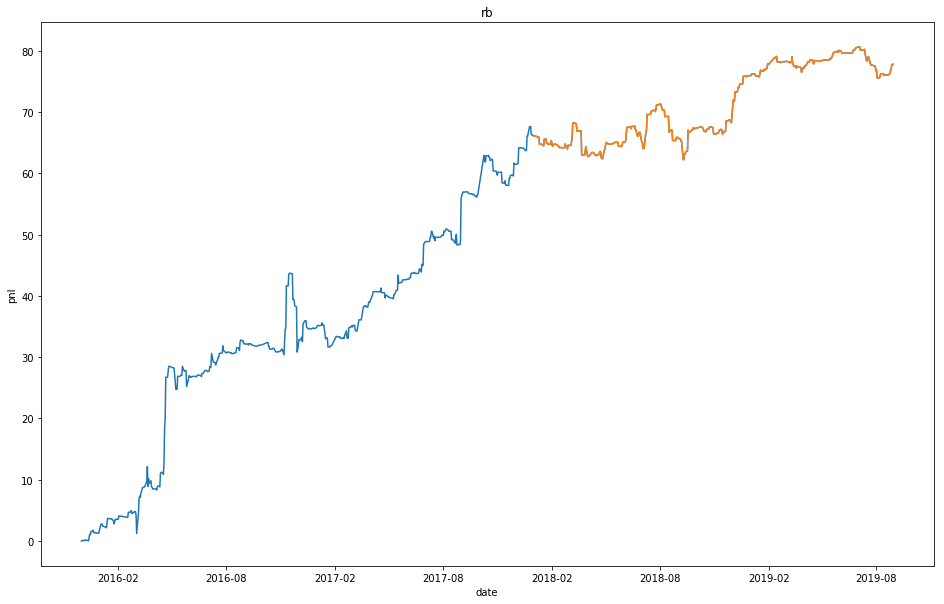

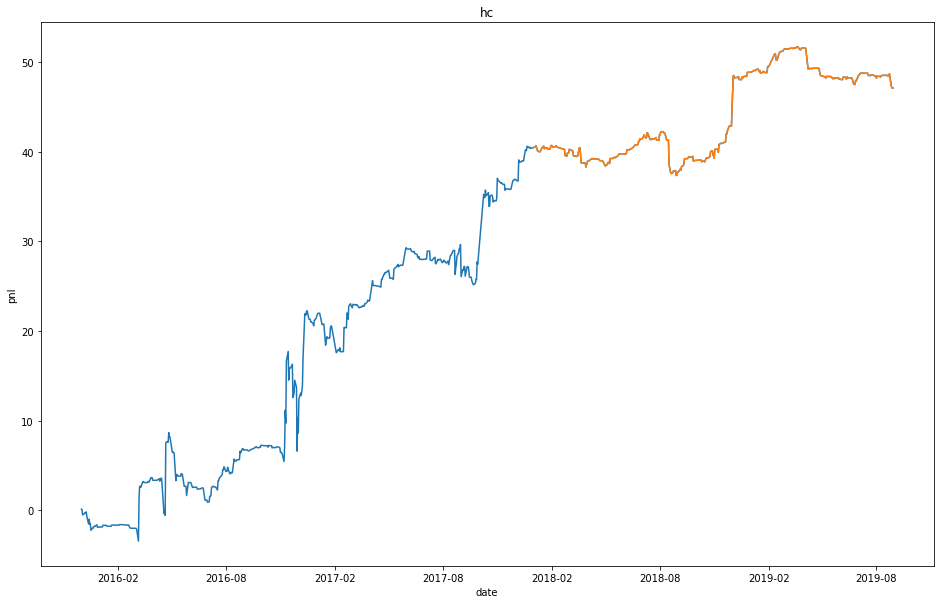

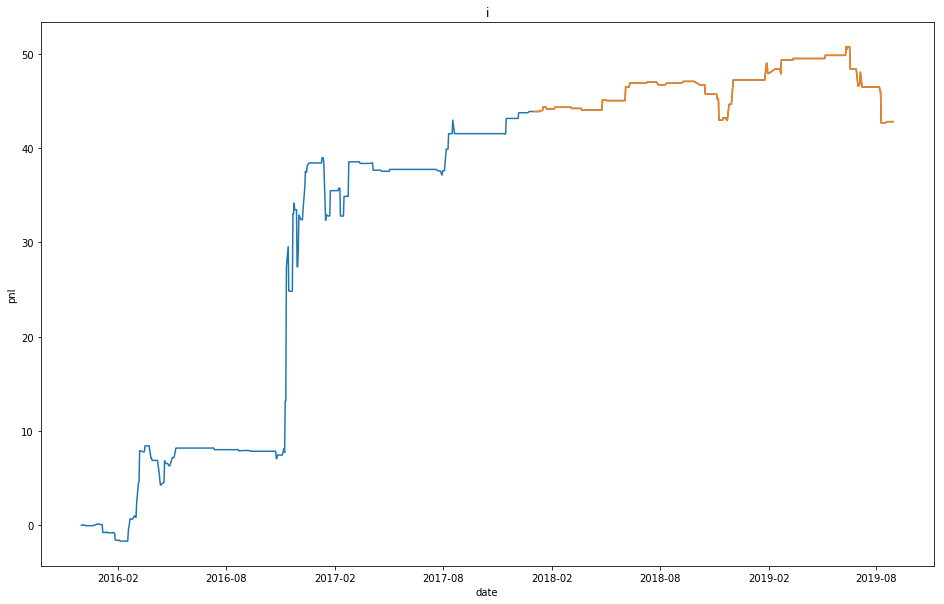

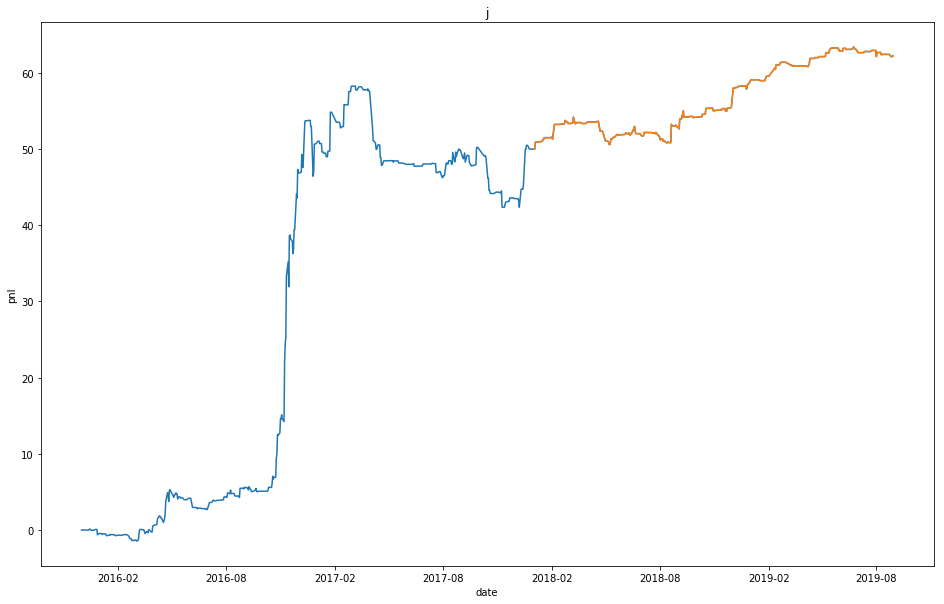

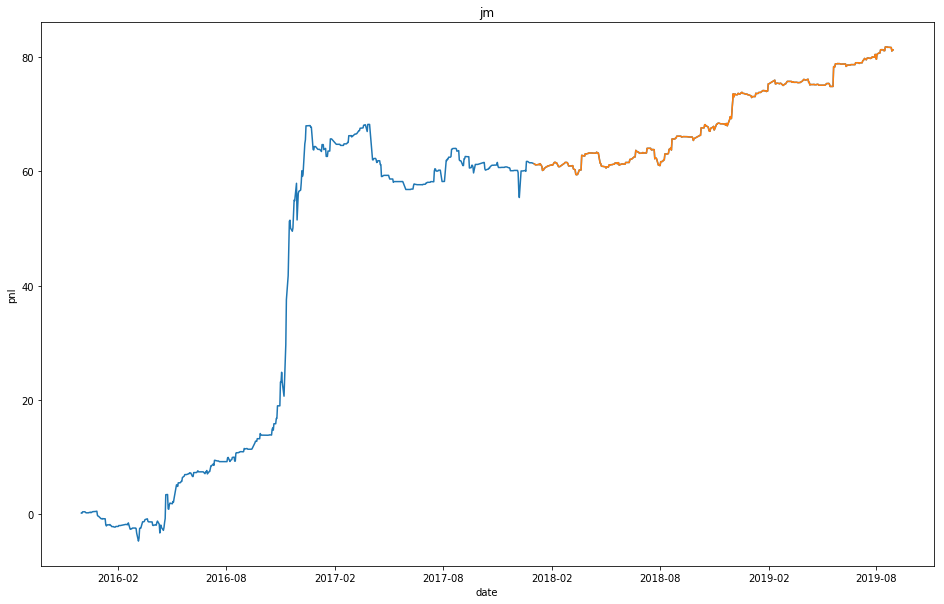

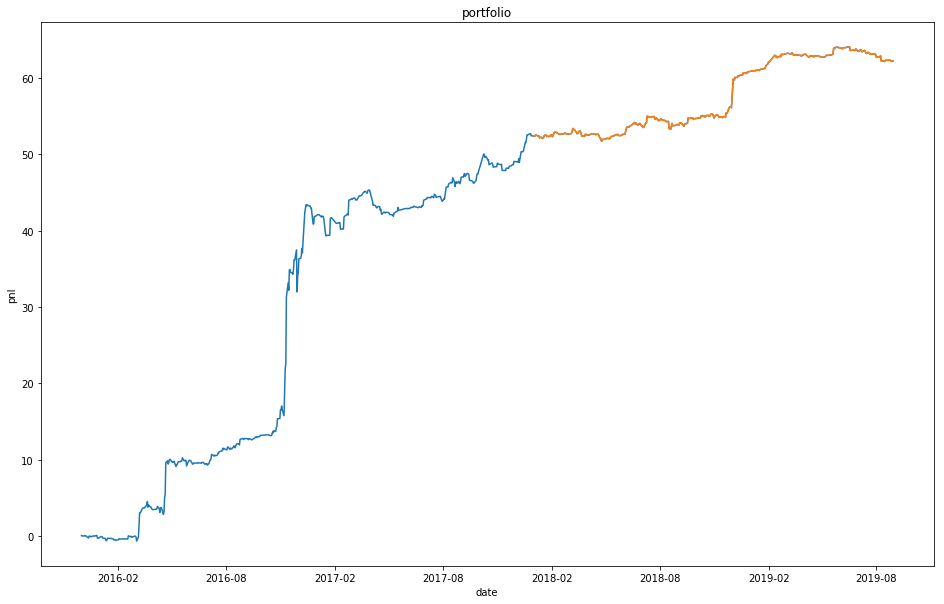

In [13]:
i = 0
result_dire = "signal result"
save_name = "chosen_strategy"
n_product = len(product_list)
portfolio = np.zeros((n_days, n_product))
for product in product_list:
    chosen_strategy, pnl_mat = load(HEAD_PATH+"/"+save_name+"/"+product+".pkl")
    avg_train_pnl = pnl_mat.mean(axis=1)
    avg_test_pnl = all_test_mat[product].mean(axis=1)
    all_pnl = np.append(avg_train_pnl, avg_test_pnl)
    all_pnl = all_pnl/np.std(avg_train_pnl)
    i = i+1
    plt.figure(i, figsize=(16, 10))
    plt.title(product)
    plt.xlabel("date")
    plt.ylabel("pnl")
    plt.plot(format_dates, all_pnl.cumsum())
    plt.plot(format_dates[test_sample], all_pnl.cumsum()[test_sample])
    #portfolio = portfolio+all_pnl/len(product_list)
    portfolio[:,i-1] = all_pnl
    print(product, "train sharpe: ", sharpe(avg_train_pnl),"test sharpe: ", sharpe(avg_test_pnl))

i = i+1
plt.figure(i, figsize=(16, 10))
plt.title("portfolio")
plt.xlabel("date")
plt.ylabel("pnl")
avg_portfolio = portfolio.mean(axis=1)
plt.plot(format_dates, avg_portfolio.cumsum())
plt.plot(format_dates[test_sample], avg_portfolio.cumsum()[test_sample])
print("portfolio", "train sharpe: ", sharpe(avg_portfolio[train_sample]),"test sharpe: ", sharpe(avg_portfolio[test_sample]))

# rb train sharpe:  1.9112008488652474 test sharpe:  0.842544614543883
# hc train sharpe:  1.1268628658959257 test sharpe:  0.7038720928673522
# i train sharpe:  1.2504704012590613 test sharpe:  -0.4972759772556132
# j train sharpe:  1.4949054954895211 test sharpe:  1.626629681203086
# jm train sharpe:  2.013534593391649 test sharpe:  1.6182948000153987
# portfolio train sharpe:  2.2232717767757655 test sharpe:  1.355575062224046



 - Now we can check the result with atr

rb train sharpe:  2.023526806238766 test sharpe:  0.5232444116620614
hc train sharpe:  1.1556855066226106 test sharpe:  0.8200532895434439
i train sharpe:  1.2294691638918014 test sharpe:  0.45693961650778275
j train sharpe:  1.557206685282056 test sharpe:  1.3970285377549077
jm train sharpe:  2.1365675220924785 test sharpe:  2.2229790138273167
portfolio train sharpe:  2.208384465461143 test sharpe:  1.684252909446142


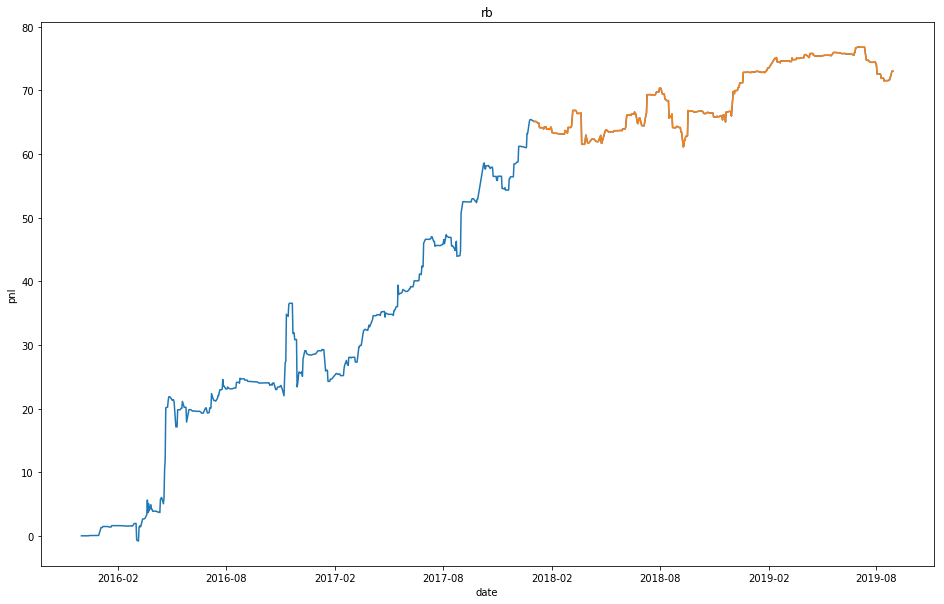

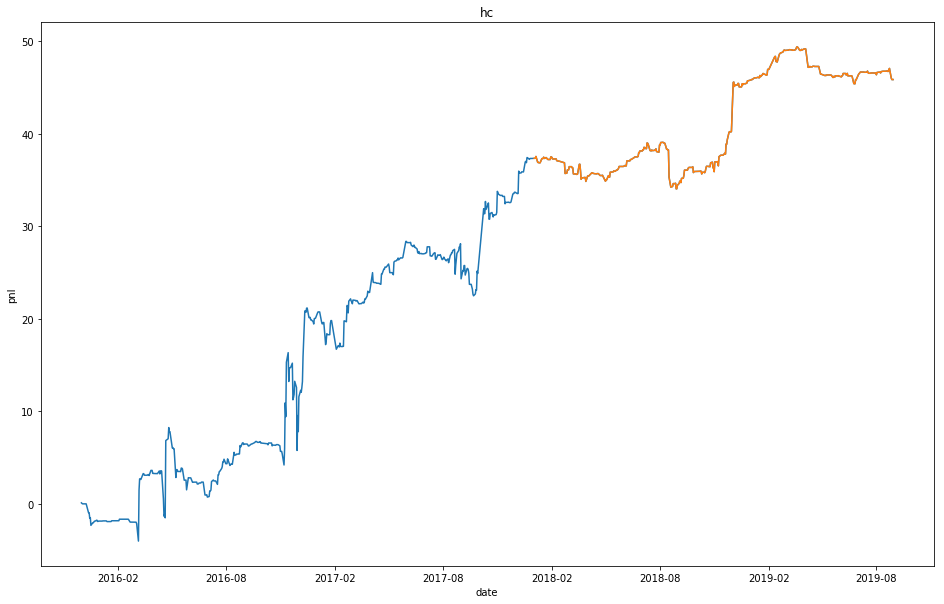

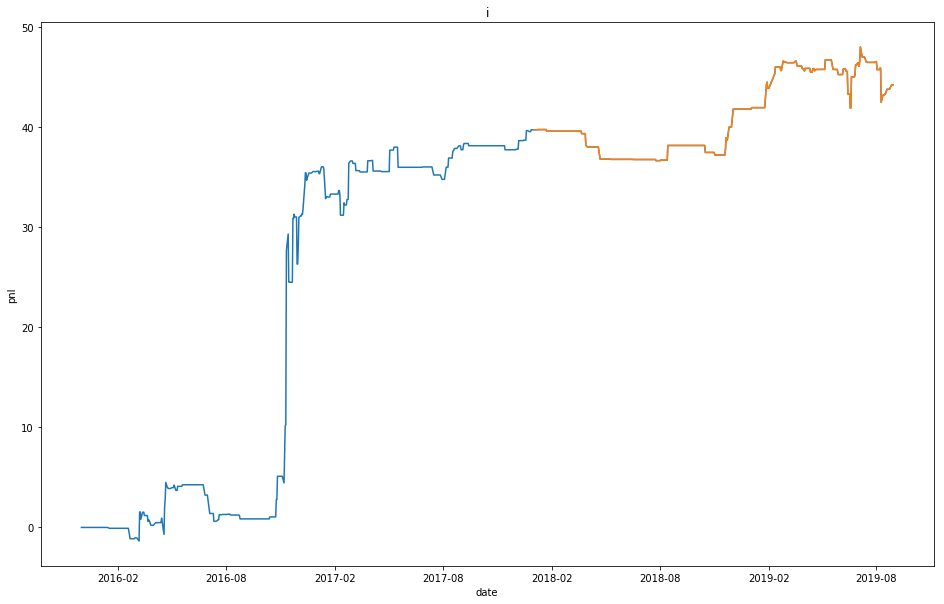

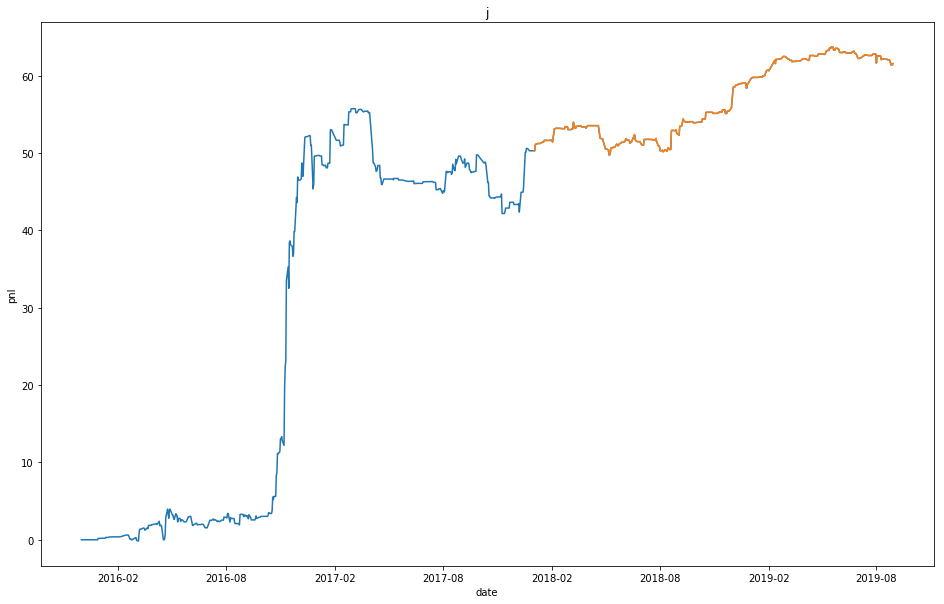

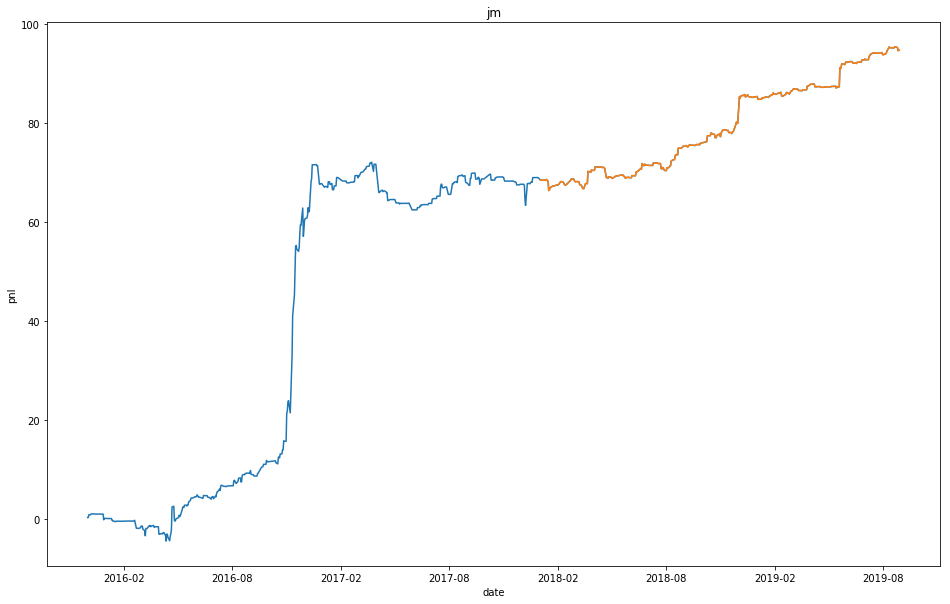

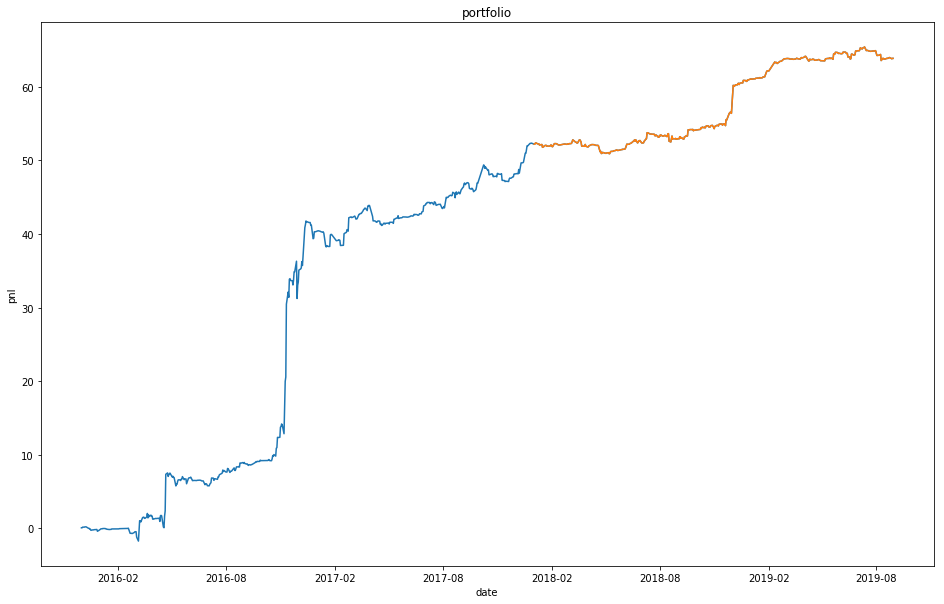

In [196]:
result_dire = "signal result atr"
save_name = "chosen_strategy_atr"
get_chosen_strategy(product_list, result_dire, save_name, min_num=20, min_pnl=2)
all_test_mat=dict([])
for product in product_list:
    chosen_strategy, pnl_mat = load(HEAD_PATH+"/"+save_name+"/"+product+".pkl")
    test_mat = functools.reduce(get_test_mat, signal_list, None)
    all_test_mat[product] = test_mat
i = 0
n_product = len(product_list)
portfolio = np.zeros((n_days, n_product))
for product in product_list:
    chosen_strategy, pnl_mat = load(HEAD_PATH+"/"+save_name+"/"+product+".pkl")
    avg_train_pnl = pnl_mat.mean(axis=1)
    avg_test_pnl = all_test_mat[product].mean(axis=1)
    all_pnl = np.append(avg_train_pnl, avg_test_pnl)
    all_pnl = all_pnl/np.std(avg_train_pnl)
    i = i+1
    plt.figure(i, figsize=(16, 10))
    plt.title(product)
    plt.xlabel("date")
    plt.ylabel("pnl")
    plt.plot(format_dates, all_pnl.cumsum())
    plt.plot(format_dates[test_sample], all_pnl.cumsum()[test_sample])
    portfolio[:,i-1] = all_pnl
    print(product, "train sharpe: ", sharpe(avg_train_pnl),"test sharpe: ", sharpe(avg_test_pnl))

i = i+1
plt.figure(i, figsize=(16, 10))
plt.title("portfolio")
plt.xlabel("date")
plt.ylabel("pnl")
avg_portfolio = portfolio.mean(axis=1)
plt.plot(format_dates, avg_portfolio.cumsum())
plt.plot(format_dates[test_sample], avg_portfolio.cumsum()[test_sample])
print("portfolio", "train sharpe: ", sharpe(avg_portfolio[train_sample]),"test sharpe: ", sharpe(avg_portfolio[test_sample]))

# rb train sharpe:  1.9902833881037125 test sharpe:  0.3274056132116756
# hc train sharpe:  1.123072957943443 test sharpe:  0.7685963691856255
# i train sharpe:  1.1556668654396114 test sharpe:  0.5320376234689764
# j train sharpe:  1.3967442823380127 test sharpe:  1.4788806740369553
# jm train sharpe:  2.1198211529499287 test sharpe:  2.184782401700687
# portfolio train sharpe:  2.159916500244985 test sharpe:  1.589439365039316

- we can see that:

conclusion
- without atr has higher train sharpe than with atr, but without atr has lower test sharpe than with atr

- without atr, i is losing money while with atr i is earning money for test samples

- the reason may be that for in-sample volatility is higher so without atr would generate good result
- however, for out-sample volatility is low so with atr the result is good
- generally, with atr the result is more stable, train and test sharpe are more close than without atr

- at first we try using the mean-variance optimization model


- we need a function to calculate weight of each strategy for a target mean


- here the meaning of each argument is
- m: vector of average daily pnl
- s: covariance matix of daily pnl
- m.star: target daily pnl, which should be within the range of lowest and highest daily pnl

In [161]:
def get_weight(m, s, m_star):
    s_inv = np.linalg.inv(s)
    ones = np.repeat(1, len(m))
    s_inv_ones = np.dot(s_inv , ones)
    s_inv_m = np.dot(s_inv , m)
    A = np.dot(m, s_inv_ones)
    B = np.dot(m, s_inv_m)
    C = np.dot(ones, s_inv_ones)
    D = B * C - A**2
    return ((B - m_star * A) * s_inv_ones + (m_star * C - A) * s_inv_m) / D

## page 86 of 《statistical models and methods for financial markets》

- get daily average pnl of each strategy

In [226]:
pnl_mat = portfolio[train_sample,:]
mean_return = pnl_mat.mean(axis=0)


- get covariance matrix of each strategy

In [227]:
cov_return = np.cov(pnl_mat, rowvar=False)
n_point = 30
n_strat = pnl_mat.shape[1]
m_grid = np.linspace(min(mean_return), max(mean_return), n_point)
m_grid

# array([0.10798074, 0.21248155, 0.31698237, 0.42148319, 0.52598401,
#        0.63048483, 0.73498565, 0.83948646, 0.94398728, 1.0484881 ,
#        1.15298892, 1.25748974, 1.36199056, 1.46649138, 1.57099219,
#        1.67549301, 1.77999383, 1.88449465, 1.98899547, 2.09349629,
#        2.1979971 , 2.30249792, 2.40699874, 2.51149956, 2.61600038,
#        2.7205012 , 2.82500202, 2.92950283, 3.03400365, 3.13850447])

array([0.07316373, 0.07530502, 0.07744631, 0.0795876 , 0.08172888,
       0.08387017, 0.08601146, 0.08815275, 0.09029403, 0.09243532,
       0.09457661, 0.0967179 , 0.09885918, 0.10100047, 0.10314176,
       0.10528304, 0.10742433, 0.10956562, 0.11170691, 0.11384819,
       0.11598948, 0.11813077, 0.12027206, 0.12241334, 0.12455463,
       0.12669592, 0.12883721, 0.13097849, 0.13311978, 0.13526107])

In [228]:
import scipy

In [229]:
E,V = scipy.linalg.eigh(cov_return)
np.all(E > 0)
## True
## it's positive defintie

True

In [230]:
cov_grid = np.repeat(np.nan, n_point)
weight_grid = np.zeros((n_strat, n_point))


In [231]:
s_inv = np.linalg.inv(cov_return)
s_inv

# array([[ 1.59614991e+01,  3.37716687e-02,  5.04767331e-02, ...,
#         -1.63917522e-02, -1.57308044e-01,  7.94896956e-03],
#        [ 3.37716687e-02,  9.75243907e-02, -9.42588553e-02, ...,
#         -1.27906534e-01,  3.94845224e-03, -4.09572906e-02],
#        [ 5.04767331e-02, -9.42588553e-02,  2.43013941e-01, ...,
#          1.20559794e-01, -8.65889022e-03,  3.91789251e-02],
#        ...,
#        [-1.63917522e-02, -1.27906534e-01,  1.20559794e-01, ...,
#          1.57520938e+00, -3.94467924e-02,  1.74289231e-01],
#        [-1.57308044e-01,  3.94845224e-03, -8.65889022e-03, ...,
#         -3.94467924e-02,  3.50093028e-01, -3.14645354e-01],
#        [ 7.94896957e-03, -4.09572906e-02,  3.91789251e-02, ...,
#          1.74289231e-01, -3.14645354e-01,  4.94656647e-01]])

array([[ 1.54308399, -0.73532199, -0.2296796 ,  0.20722333, -0.33120385],
       [-0.73532199,  1.61400544, -0.24189475, -0.38202216,  0.11871463],
       [-0.2296796 , -0.24189475,  1.54296923, -0.51801161, -0.20425224],
       [ 0.20722333, -0.38202216, -0.51801161,  2.02247375, -1.02663874],
       [-0.33120385,  0.11871463, -0.20425224, -1.02663874,  1.82601915]])

In [232]:
for i in range(1, n_point-1):
    w = get_weight(mean_return, cov_return, m_grid[i])
    cov_grid[i] = np.sqrt(np.dot(np.dot(w, cov_return), w))
    weight_grid[:,i] = w
## here we don't use the first value and last value to avoid scientific computing error

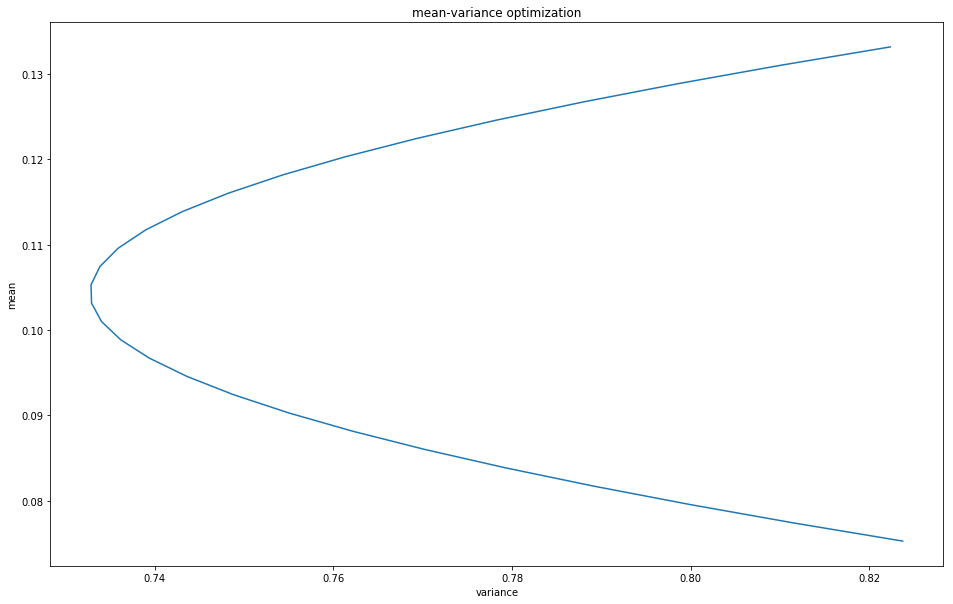

In [233]:
plt.figure(1, figsize=(16, 10))
plt.title("mean-variance optimization")
plt.xlabel("variance")
plt.ylabel("mean")
plt.plot(cov_grid, m_grid);

- to avoid using the mean return we can use risk parity model

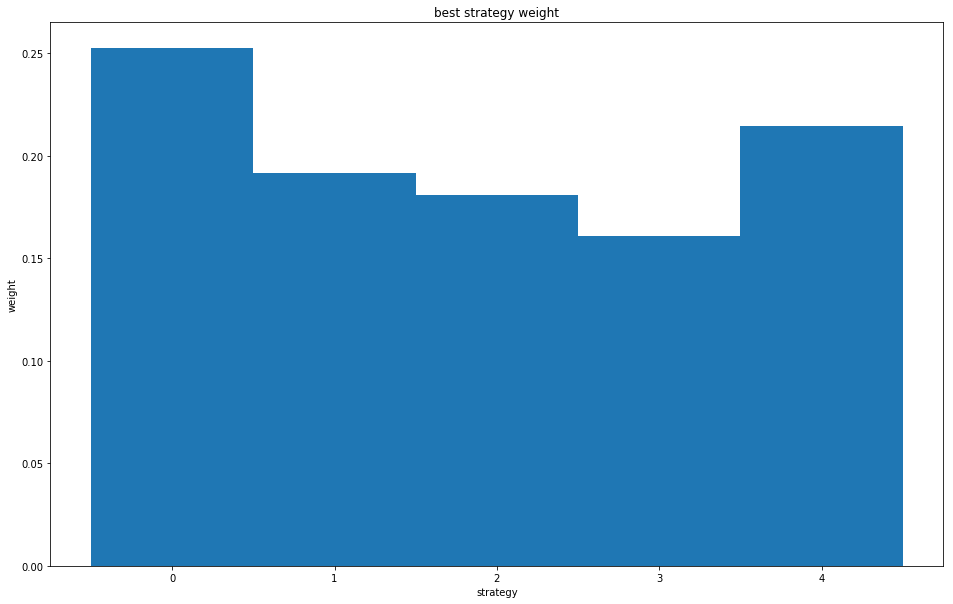

In [234]:
best_index = np.nanargmin(cov_grid)
best_weight = weight_grid[:, best_index]
best_weight = pd.Series(best_weight)
plt.figure(1, figsize=(16, 10))
plt.title("best strategy weight")
plt.xlabel("strategy")
plt.ylabel("weight")
plt.bar(best_weight.index.values, best_weight.values, width=1);

- we can see that there are some negative weights
- although we can do long and short for trading commodities
- here we optimize on the strategies, which we think are good in the training set
- so it does not make sense to short a good strategy
- we also find that there are some large positive and negative weight in magnitude
- it may lead to overfitting to the training data as well
- let's see how to avoid these

- at first  we try to use this without nonnegative constraint


- we construct the matrix to be used in quadratic programming

In [235]:
A_mat = np.vstack((np.repeat(1, n_strat), mean_return)).T
n_strat

5

In [236]:
# https://pypi.org/project/quadprog/
# pip install quadprog
# need to download visual studio before running
import quadprog as qp

In [237]:
m_grid[best_index]
# 0.21248155375252883

0.10528304490828325

In [238]:
sol = qp.solve_qp(G=cov_return, a=np.zeros(n_strat), C=A_mat, b=np.array([1, m_grid[best_index]]), meq=2)
sol[0]

# array([ 2.91578353e+00, -2.92450987e-01,  9.90149223e-02, -3.14421429e+00,
#         2.01119695e-01,  6.43344632e-01,  3.43098510e-02, -7.16590512e-01,
#         6.16088875e-01, -7.28211545e-01, -9.34284341e-01,  6.91734534e-01,
#         2.32455945e-01,  5.28790341e-01, -2.73973963e-01,  6.20108136e-01,
#         2.72303809e+00, -2.82218818e+00, -2.24140455e-01, -5.22096612e-01,
#         8.25433469e-02,  1.50815965e+00, -1.50001518e+00,  1.28670416e-01,
#         4.43580193e-01, -8.79798868e-01,  3.15015312e-01, -2.64930278e+00,
#         2.14593827e+00, -1.26146309e+00,  3.20933227e+00,  1.15671972e+00,
#         9.85484938e+00, -1.27987234e+01,  3.53243690e+00, -3.08560425e-01,
#        -3.51351219e-01, -3.04912074e+00,  3.56373556e-01, -9.52273371e-02,
#        -2.21489928e-01,  3.04339863e-01,  6.14824892e-01,  1.21860064e-01,
#         5.37684327e-04, -3.14231085e+00,  1.71227507e+00,  1.59751350e+00,
#         3.89375342e-01,  1.90230409e-01,  2.76133497e-01, -1.10527943e+00,
#         3.54842280e-01,  8.24659511e-02,  4.10620977e-02,  3.24037176e-01,
#        -2.24997589e-01,  3.26568216e-01, -2.89477597e-01, -1.28121774e-01,
#         2.53013890e-01, -2.65755496e-01,  3.03505415e-01,  3.85599069e-01,
#        -4.43697013e-01,  6.99990742e-02, -8.28962250e-02,  6.81487788e-02])

array([0.25252156, 0.19164656, 0.18071303, 0.1606544 , 0.21446444])

In [239]:
sum(abs(sol[0] - best_weight) > 0.00001)

0

In [240]:
A_mat = np.vstack((np.repeat(1, n_strat), mean_return, np.diag(np.repeat(1, n_strat)))).T
A_mat.shape

(5, 7)

In [241]:
sol_nneg = qp.solve_qp(G=cov_return, a=np.zeros(n_strat), C=A_mat, b=np.hstack((1, m_grid[best_index], np.zeros(n_strat))), meq=2)
sol_nneg[0]

array([0.25252156, 0.19164656, 0.18071303, 0.1606544 , 0.21446444])

- we can see that there are many tiny positive values due to rounding error
- so we can use a small positive number to avoid it

In [242]:
sol_nneg = qp.solve_qp(G=cov_return, a=np.zeros(n_strat), C=A_mat, b=np.hstack((1, m_grid[best_index], np.repeat(1e-5, n_strat))), meq=2)
sol_nneg[0]

## array([0.21272401, 0.19916702, 0.20664672, 0.19826156, 0.18320068])

array([0.25252156, 0.19164656, 0.18071303, 0.1606544 , 0.21446444])

- however, now the problem is that there are too many 1e-5s, and the tenth strategy has portion of 0.59
- that may be overfitting to that strategy
- if it performs worse inthe testing samples our overall result would be very bad
- let's set a limit for the maximum portion of each strategy
- average strategy is 

In [243]:
1/n_strat

0.2

- we can set maximum to be 7%
- but then we may not get the optimal mean values
- so we need to restart the whole optimization scheme again

In [244]:
A_mat = np.vstack((np.repeat(1, n_strat), mean_return, np.diag(np.repeat(1, n_strat)), -np.diag(np.repeat(1, n_strat)))).T
cov_grid = np.repeat(np.nan, n_point)
for i in range(1, n_point-1):
    try:
        sol_nneg = qp.solve_qp(G=cov_return, a=np.zeros(n_strat), C=A_mat, 
                               b=np.hstack((1, m_grid[i], np.repeat(1e-5, n_strat), np.repeat(-0.3, n_strat))), meq=2)
    except ValueError:
        continue
    w = sol_nneg[0]
    cov_grid[i] = np.sqrt(np.dot(np.dot(w, cov_return), w))
    weight_grid[:,i] = w

In [245]:
best_index = np.nanargmin(cov_grid)
weight_grid[:, best_index]

array([0.25252156, 0.19164656, 0.18071303, 0.1606544 , 0.21446444])

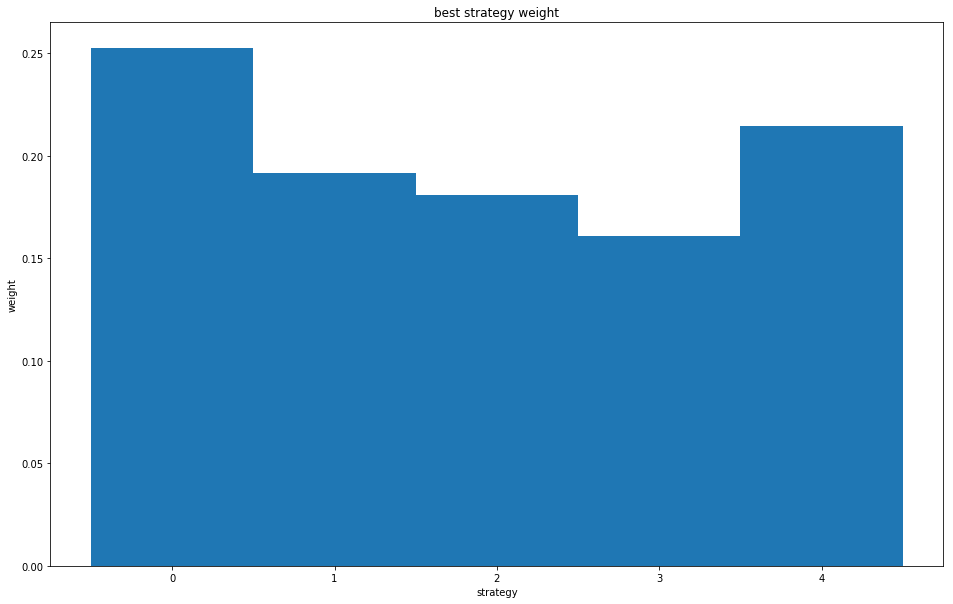

In [246]:
plt.figure(1, figsize=(16, 10))
plt.title("best strategy weight")
plt.xlabel("strategy")
plt.ylabel("weight")
plt.bar(np.linspace(0, len(weight_grid)-1, len(weight_grid)), weight_grid[:, best_index], width=1);

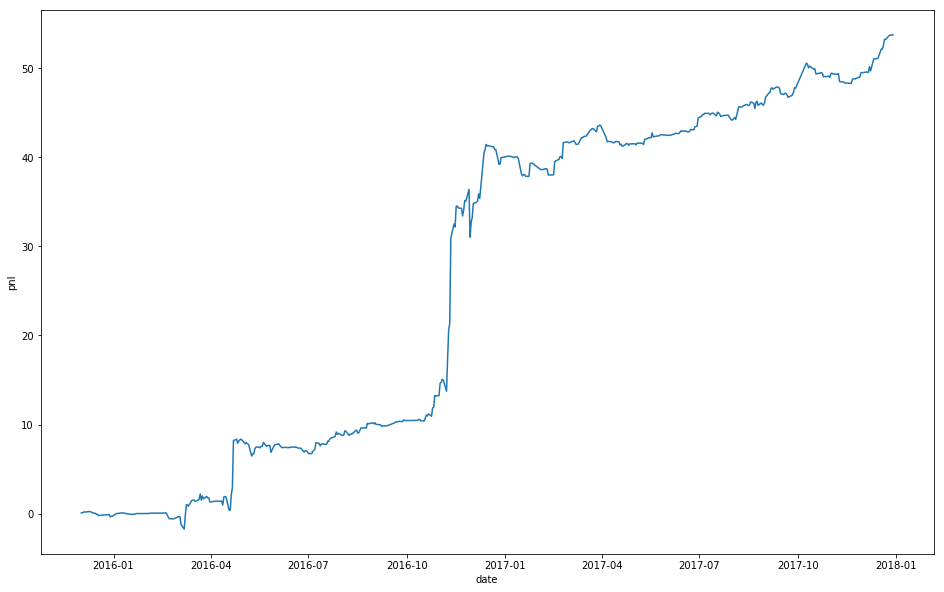

In [249]:
best_weight = weight_grid[:, best_index]
best_weight = pd.Series(best_weight)
best_weight[best_weight<1.1e-5] = 0
train_pnl = np.dot(pnl_mat, best_weight)
train_pnl = pd.Series(train_pnl)
plt.figure(1, figsize=(16, 10))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[train_sample], train_pnl.cumsum());

In [250]:
sharpe(train_pnl)
## 2.271436288662217

2.271436288662217

In [255]:
test_mat = portfolio[test_sample,:]
test_pnl = np.dot(test_mat, best_weight)

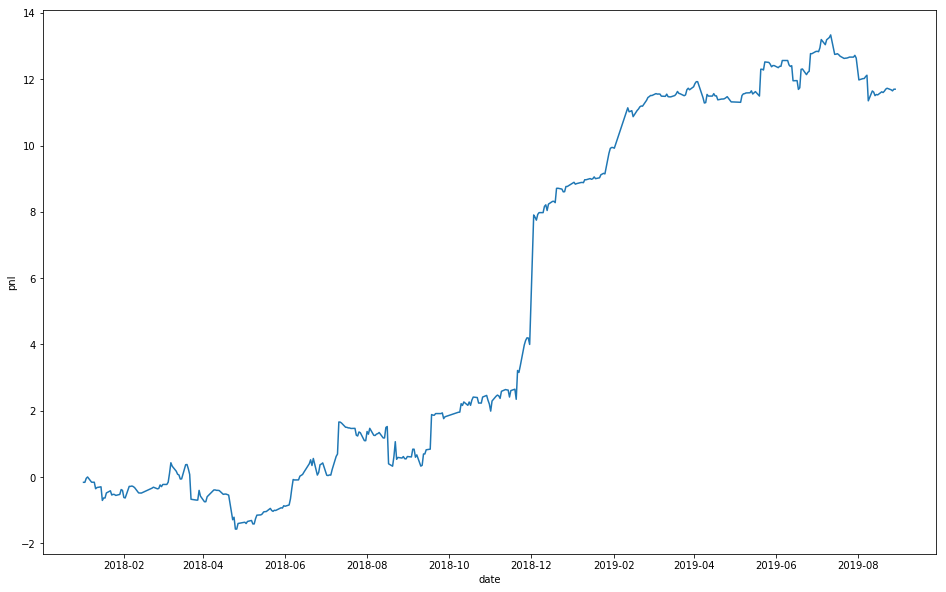

In [256]:
test_pnl = np.dot(test_mat, best_weight)
test_pnl = pd.Series(test_pnl)
plt.figure(1, figsize=(16, 10))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[test_sample], test_pnl.cumsum());

In [257]:
sharpe(test_pnl)

#1.6407742230819167

1.6407742230819167

In [258]:
import copy

'''
    Pure Python/Numpy implementation of the Nelder-Mead algorithm.
    Reference: https://en.wikipedia.org/wiki/Nelder%E2%80%93Mead_method
'''


def nelder_mead(f, x_start,
                step=0.1, no_improve_thr=10e-6,
                no_improv_break=10, max_iter=0,
                alpha=1., gamma=2., rho=-0.5, sigma=0.5):
    '''
        @param f (function): function to optimize, must return a scalar score
            and operate over a numpy array of the same dimensions as x_start
        @param x_start (numpy array): initial position
        @param step (float): look-around radius in initial step
        @no_improv_thr,  no_improv_break (float, int): break after no_improv_break iterations with
            an improvement lower than no_improv_thr
        @max_iter (int): always break after this number of iterations.
            Set it to 0 to loop indefinitely.
        @alpha, gamma, rho, sigma (floats): parameters of the algorithm
            (see Wikipedia page for reference)
        return: tuple (best parameter array, best score)
    '''

    # init
    dim = len(x_start)
    prev_best = f(x_start)
    no_improv = 0
    res = [[x_start, prev_best]]

    for i in range(dim):
        x = copy.copy(x_start)
        x[i] = x[i] + step
        score = f(x)
        res.append([x, score])

    # simplex iter
    iters = 0
    while 1:
        # order
        res.sort(key=lambda x: x[1])
        best = res[0][1]

        # break after max_iter
        if max_iter and iters >= max_iter:
            return res[0]
        iters += 1

        # break after no_improv_break iterations with no improvement
        print ('...best so far:', best)

        if best < prev_best - no_improve_thr:
            no_improv = 0
            prev_best = best
        else:
            no_improv += 1

        if no_improv >= no_improv_break:
            return res[0]

        # centroid
        x0 = [0.] * dim
        for tup in res[:-1]:
            for i, c in enumerate(tup[0]):
                x0[i] += c / (len(res)-1)

        # reflection
        xr = x0 + alpha*(x0 - res[-1][0])
        rscore = f(xr)
        if res[0][1] <= rscore < res[-2][1]:
            del res[-1]
            res.append([xr, rscore])
            continue

        # expansion
        if rscore < res[0][1]:
            xe = x0 + gamma*(x0 - res[-1][0])
            escore = f(xe)
            if escore < rscore:
                del res[-1]
                res.append([xe, escore])
                continue
            else:
                del res[-1]
                res.append([xr, rscore])
                continue

        # contraction
        xc = x0 + rho*(x0 - res[-1][0])
        cscore = f(xc)
        if cscore < res[-1][1]:
            del res[-1]
            res.append([xc, cscore])
            continue

        # reduction
        x1 = res[0][0]
        nres = []
        for tup in res:
            redx = x1 + sigma*(tup[0] - x1)
            score = f(redx)
            nres.append([redx, score])
        res = nres

In [259]:
from scipy.optimize import minimize
def TotalTRC(x, Cov):
    x = np.append(x, 1-np.sum(x))
    TRC = np.prod((np.dot(Cov, x), x), axis=0)
    if np.sum(x<0)>0: 
        return 10**12
    else:
        return np.sum((TRC[:, None] - TRC) ** 2)
    
def risk_parity(Sub, only_diag=False, maxiter=9999):
    m = Sub.shape[1]
    Cov = np.cov(Sub, rowvar=False)
    if only_diag:
        Cov = np.diag(np.diag(Cov))
    res = minimize(functools.partial(TotalTRC, Cov=Cov), np.repeat(1/m, m-1), method="Nelder-Mead", options={'xtol': 1e-6, "maxiter": maxiter, "disp":True})
    w = np.append(res["x"], 1-np.sum(res["x"]))
    #res = nelder_mead(functools.partial(TotalTRC, Cov=Cov), np.repeat(1/m, m-1), step=1e-3, no_improve_thr=1e-05)
    #w = np.append(res[0], 1-np.sum(res[0]))
    return w

- get weight of risk parity

In [260]:
parity_weight = risk_parity(pnl_mat)
parity_weight = pd.Series(parity_weight)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 74
         Function evaluations: 141


- plot the weight

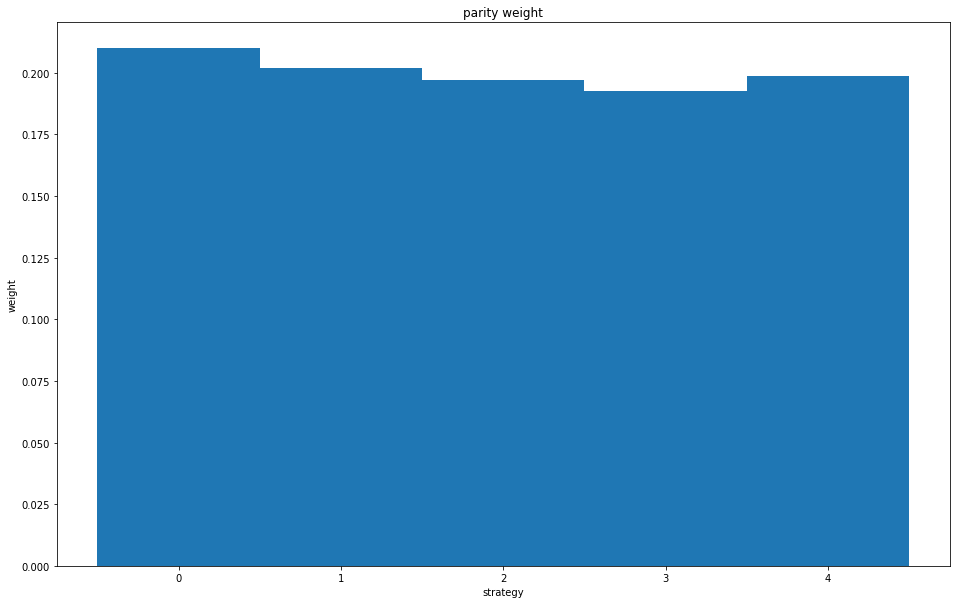

In [261]:
plt.figure(1, figsize=(16, 10))
plt.title("parity weight")
plt.xlabel("strategy")
plt.ylabel("weight")
plt.bar(parity_weight.index, parity_weight.values, width=1);

- check negative weight

In [262]:
sum(parity_weight<0)
## [1] 0

0

- check the result on training samples

In [263]:
train_parity = np.dot(pnl_mat, parity_weight)
train_parity = pd.Series(train_parity)

- and plot the final pnl

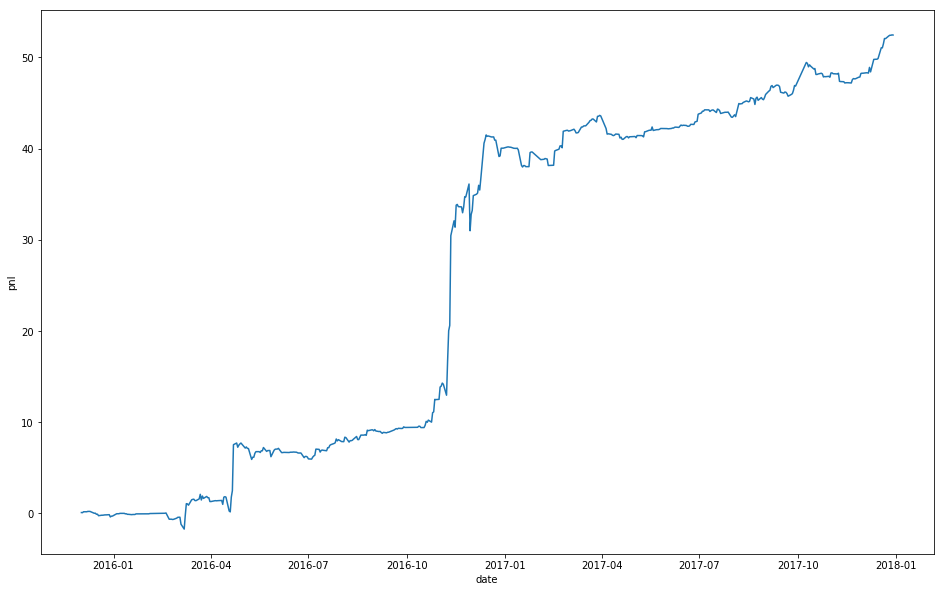

In [264]:
plt.figure(1, figsize=(16, 10))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[train_sample], train_parity.cumsum());

- calculate the sharp ratio

In [266]:
sharpe(train_parity)
## 2.215972613717579

2.215972613717579

- now we check the performance on out-of-sample data

In [267]:
test_parity = np.dot(test_mat, parity_weight)
test_parity = pd.Series(test_parity)

- and plot the final pnl

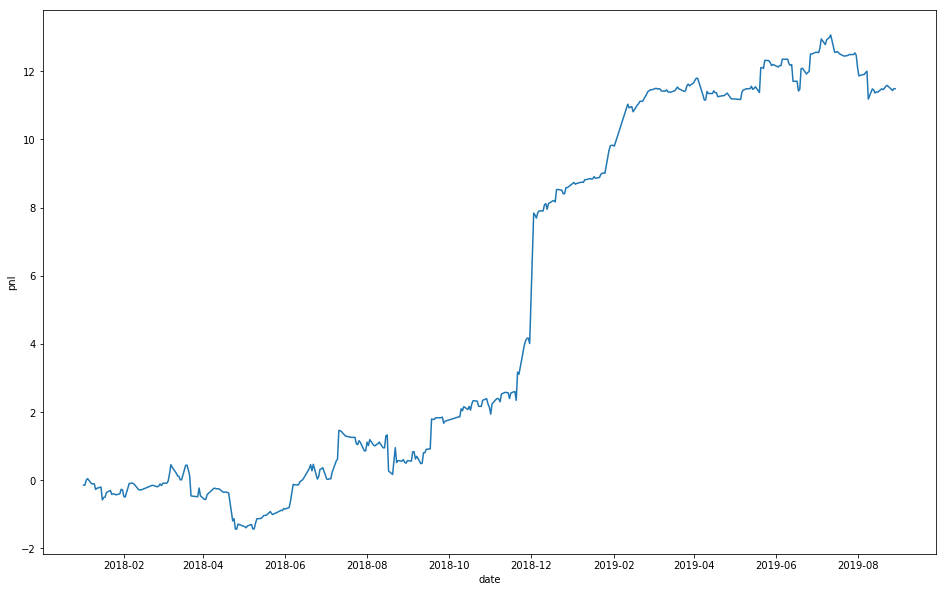

In [268]:
plt.figure(1, figsize=(16, 10))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[test_sample], test_parity.cumsum());

- calculate the sharp ratio

In [270]:
sharpe(test_parity)
## 1.6663197204506068
## it's also very similar to the average weight result

1.6663197204506068

- now we get back to the estimation of covariance matrix
- somebody claims that we can simply use diagonal values and set other zero
- let's try it

- get weight of risk parity

In [271]:
diagonal_weight = risk_parity(pnl_mat, only_diag=True)
diagonal_weight = pd.Series(diagonal_weight)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 112
         Function evaluations: 171


- plot the weight

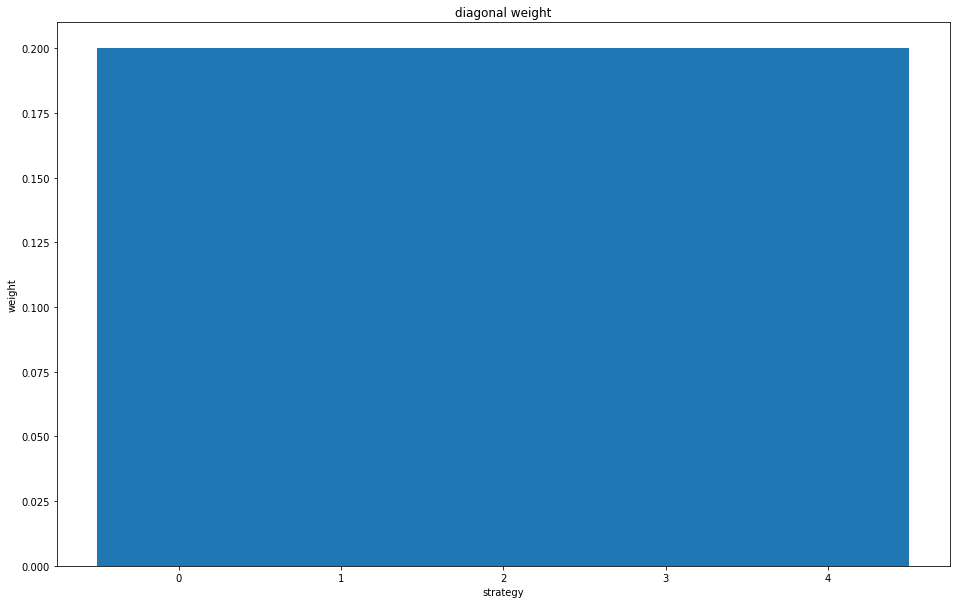

In [272]:
plt.figure(1, figsize=(16, 10))
plt.title("diagonal weight")
plt.xlabel("strategy")
plt.ylabel("weight")
plt.bar(diagonal_weight.index, diagonal_weight.values, width=1);

- check negative weight

In [273]:
sum(parity_weight<0)
## [1] 0

0

- check the result on training samples

In [274]:
train_diagonal = np.dot(pnl_mat, diagonal_weight)
train_diagonal = pd.Series(train_diagonal)

- and plot the final pnl

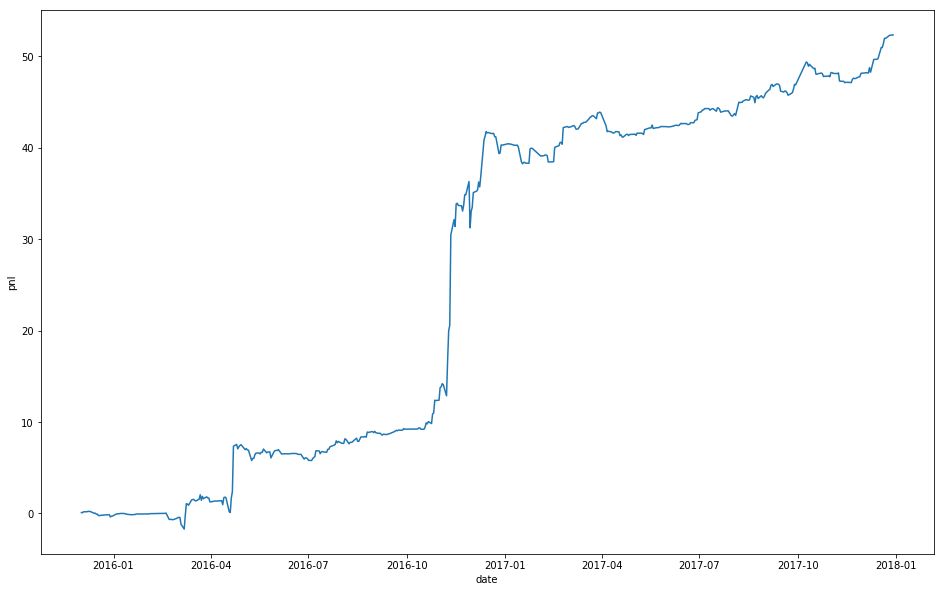

In [275]:
plt.figure(1, figsize=(16, 10))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[train_sample], train_diagonal.cumsum());

- calculate the sharp ratio

In [277]:
sharpe(train_diagonal)
## 2.2083844654611426

2.2083844654611426

- now we check the performance on out-of-sample data

In [278]:
test_diagonal = np.dot(test_mat, diagonal_weight)
test_diagonal = pd.Series(test_diagonal)

- and plot the final pnl

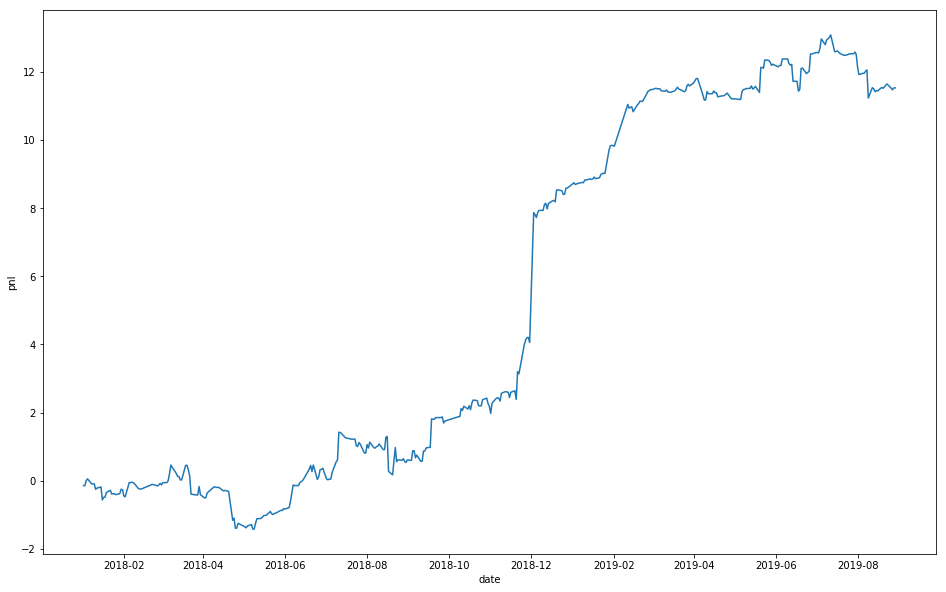

In [279]:
plt.figure(1, figsize=(16, 10))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[test_sample], test_diagonal.cumsum());

- calculate the sharp ratio

In [280]:
sharpe(test_diagonal)
## 1.6842529094461425

1.6842529094461425

- now let's get the next weight: weight based on sharpe ratio

In [281]:
sharpe_mat = np.apply_along_axis(sharpe, 0, pnl_mat)
sharpe_weight = zero_divide(sharpe_mat, np.sum(sharpe_mat))
sharpe_weight = pd.Series(sharpe_weight)

In [282]:
train_sharpe = np.dot(pnl_mat, sharpe_weight)
train_sharpe = pd.Series(train_sharpe)

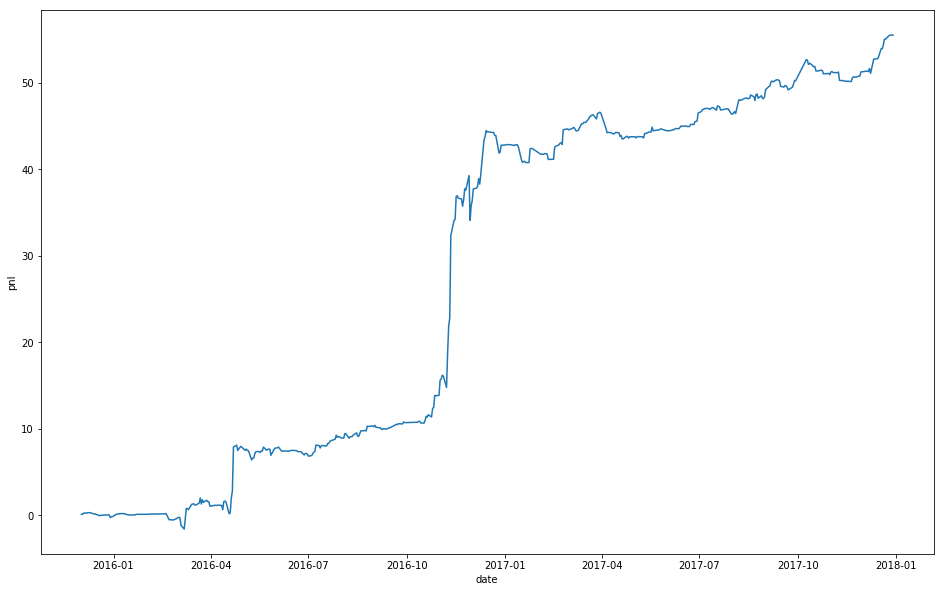

In [283]:
plt.figure(1, figsize=(16, 10))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[train_sample], train_sharpe.cumsum());

In [284]:
sharpe(train_sharpe)
## 2.335074183506421

2.335074183506421

In [285]:
test_sharpe = np.dot(test_mat, sharpe_weight)
test_sharpe = pd.Series(test_sharpe)

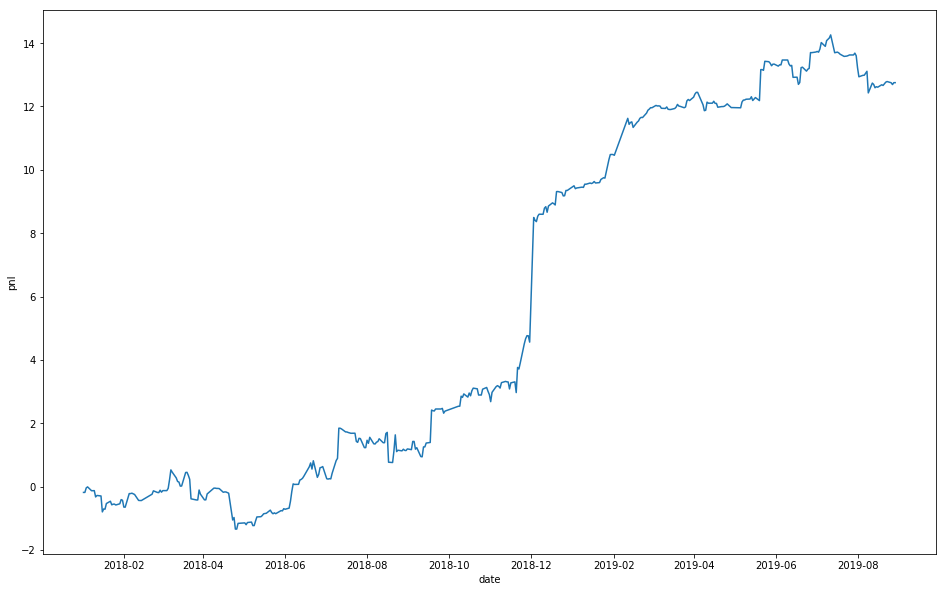

In [286]:
plt.figure(1, figsize=(16, 10))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[test_sample], test_sharpe.cumsum());

In [287]:
sharpe(test_sharpe)
## 1.7983288729778182

1.7983288729778182

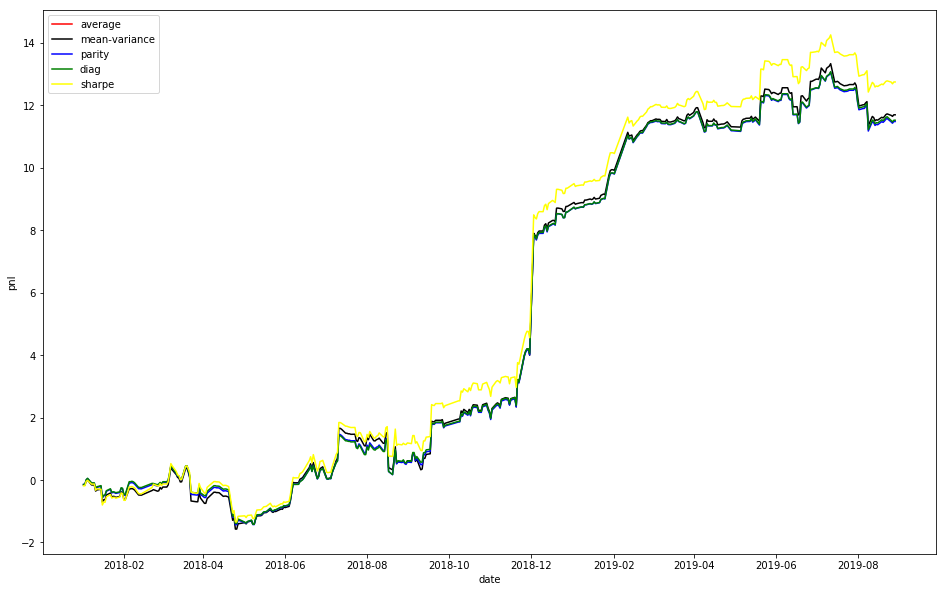

In [292]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
plt.figure(1, figsize=(16, 10))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
#avg_plot, = plt.plot(format_dates[test_sample], avg_portfolio.mean(axis=1).cumsum(), color="red", label="average");
mean_plot, = plt.plot(format_dates[test_sample], test_pnl.cumsum(), color="black", label="mean-variance");
parity_plot, = plt.plot(format_dates[test_sample], test_parity.cumsum(), color="blue", label="parity");
diag_plot, = plt.plot(format_dates[test_sample], test_diagonal.cumsum(), color="green", label="diag");
sharpe_plot, = plt.plot(format_dates[test_sample], test_sharpe.cumsum(), color="yellow", label="sharpe");
plt.legend(handles=[avg_plot, mean_plot,parity_plot, diag_plot, sharpe_plot])

- we can see that mean-variance performs the worst while avergage performs the best in pnl
- risk parity performs best when consider test sharpe ratio
- generally we can use risk parity in the future
- The last part we go to PCA

In [406]:
 from sklearn.decomposition import PCA

In [433]:
pca = PCA(n_components=0.95)
pca.fit(pnl_mat)

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [434]:
rotation = pca.components_.transpose()
rotation

array([[ 1.57037119e-01, -1.34637617e-01, -4.35249657e-02,
         9.60054366e-02, -4.30813929e-02, -8.97061414e-02,
        -3.79518370e-02,  1.49011703e-01],
       [ 1.67510298e-01, -1.20484435e-01, -4.37195996e-02,
         1.26118397e-01, -5.55024278e-02, -9.92791114e-02,
         3.14484298e-02, -8.26066420e-02],
       [ 1.63158702e-01, -1.27577232e-01, -3.51205396e-02,
         1.04149919e-01, -4.40065851e-02, -9.11092130e-02,
        -8.56507675e-03,  7.62276197e-02],
       [ 1.56912988e-01, -1.34618147e-01, -4.30885116e-02,
         9.65038314e-02, -4.30855781e-02, -9.04489514e-02,
        -4.01004591e-02,  1.51465523e-01],
       [ 1.62565067e-01, -1.28433211e-01, -3.60014527e-02,
         9.80572464e-02, -5.33971635e-02, -8.88840830e-02,
        -5.83878134e-03,  8.87379138e-02],
       [ 1.95743228e-01, -1.94058961e-01,  1.58973011e-02,
        -9.76782676e-02,  7.59818449e-02,  1.25680318e-01,
         3.95649257e-02, -1.22706146e-01],
       [ 1.94148086e-01, -1.537417

In [16]:
train_pca = p.mean(np.matmul(pnl_mat,rotation), axis=1)

(510, 105)

In [436]:
sharpe(train_pca)
## 1.6367926564835975

1.6367926564835975

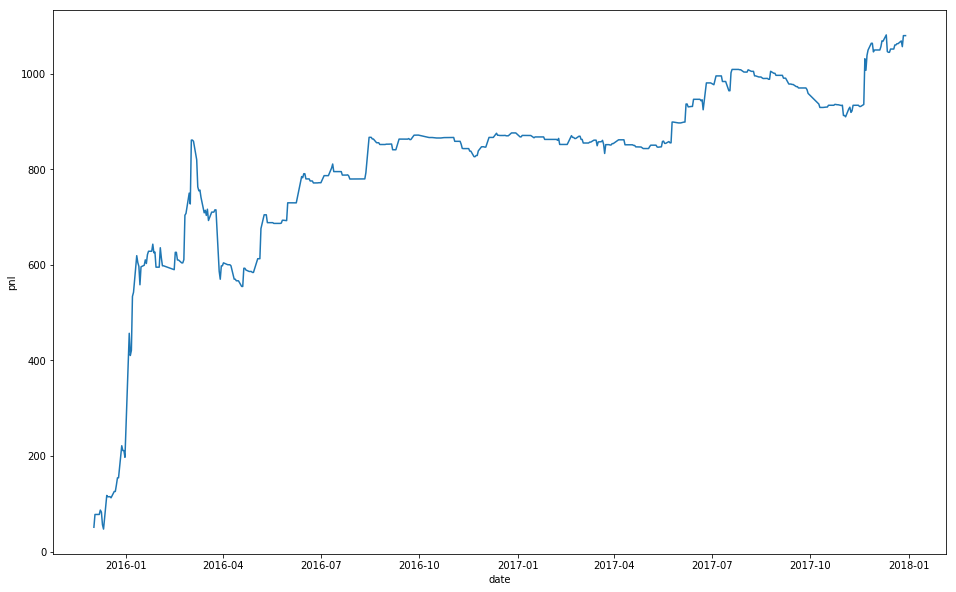

In [437]:
plt.figure(1, figsize=(16, 10))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[train_sample], train_pca.cumsum())

In [438]:
test_pca = np.mean(np.matmul(test_mat,rotation), axis=1)

In [439]:
sharpe(test_pca)
## 1.6881843152563132

1.6881843152563132

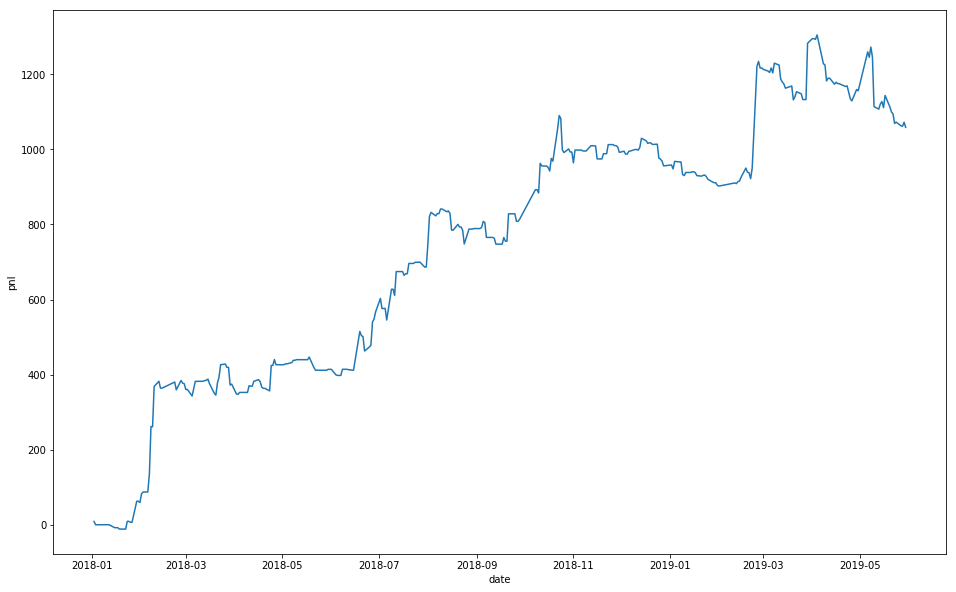

In [440]:
plt.figure(1, figsize=(16, 10))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[test_sample], test_pca.cumsum());